<div style="background: linear-gradient(135deg, #1a1a2e 0%, #16213e 100%); color: white; padding: 40px; margin: -10px -10px 20px -10px; border-radius: 0 0 15px 15px;">
<h1 style="margin: 0; font-size: 2.5em;">RTL Design & Verification</h1>
<p style="margin: 10px 0 0 0; font-size: 1.2em; opacity: 0.9;">Week 3, Session 1 — Fab Futures</p>
</div>

## Contents

- [Key Concepts: Flip-Flops and Latches](#key-concepts) — *Read this first!*

1. [What is RTL?](#1-what-is-rtl)
2. [Verilog Basics](#2-verilog-basics)
3. [Combinational Logic](#3-combinational-logic)
4. [Sequential Logic](#4-sequential-logic)
5. [State Machines](#5-state-machines)
6. [Testbenches](#6-testbenches)
7. [Self-Checking Testbenches](#7-self-checking-testbenches)
8. [Clock Domain Crossing](#8-clock-domain-crossing)
9. [Advanced Constructs](#9-advanced-constructs)
10. [Common Mistakes](#10-common-mistakes)
11. [Lint Warnings](#11-lint-warnings)

---
<a id="key-concepts"></a>
## Key Concepts: Flip-Flops and Latches

Before diving in, let's clarify two terms you'll see throughout this notebook:

### Flip-Flop (Good)

A **flip-flop** is like a **light switch** — it stays wherever you put it (on or off) until someone changes it.

More precisely, a flip-flop captures its input only at a specific moment — the clock edge:

```
       D ─────┬─────────────────────
              │
      CLK ────┼──╱╲──────────────── (rising edge)
              │
        Q ────┴─────────────────────
              │
              └── Q changes HERE, only at clock edge
```

- **Predictable**: Output only changes at clock edges
- **Synchronous**: All flip-flops update together
- **What we want** in digital design

### Latch (Usually Bad)

A **latch** is "transparent" — it passes input to output whenever enabled:

```
       D ─────┬─────────────────────
              │
   Enable ════╪════════════════════ (held high)
              │
        Q ────┴───────────────────── Q follows D continuously!
```

- **Unpredictable timing**: Output can change anytime enable is high
- **Hard to analyze**: Tools can't easily verify timing
- **Usually a mistake** in synchronous design

### Why Latches Are Usually Bugs

When you write combinational logic but forget to assign a value in all cases:

```verilog
always @(*) begin
    if (sel)
        y = a;    // What if sel=0? y must hold its old value...
                  // That requires memory → latch inferred!
end
```

The synthesis tool creates a latch to "remember" the old value. This is almost never what you want.

**The fix**: Always assign a value in every branch (or use a default).

---

In [1]:
# Setup
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import FancyBboxPatch, Circle, FancyArrowPatch
import numpy as np

print("Setup complete.")

Setup complete.


---
<a id="1-what-is-rtl"></a>
# 1. What is RTL?
---

**RTL** (Register-Transfer Level) describes digital circuits in terms of:

- **Registers** (flip-flops that store data)
- **Combinational logic** (transforms data between registers)
- **Transfers** (data moving from one register to another)

### Abstraction Levels

| Level | Description | Example |
|-------|-------------|--------|
| **Behavioral** | What the circuit does | `y = a + b` |
| **RTL** | Registers + logic | `always @(posedge clk) y <= a + b;` |
| **Gate** | Logic gates | AND, OR, XOR, flip-flops |
| **Transistor** | NMOS/PMOS | Circuit-level |

We write at the **RTL level** and let tools convert to gates.

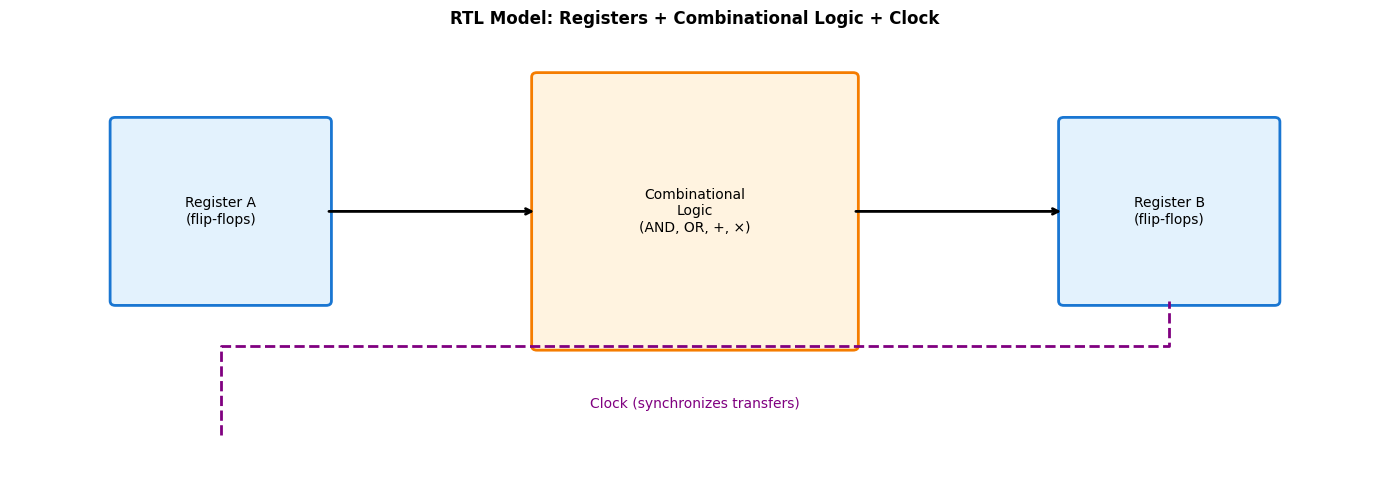

In [2]:
# RTL concept: Registers + Combinational Logic
fig, ax = plt.subplots(figsize=(14, 5))

# Register 1
ax.add_patch(FancyBboxPatch((1, 2), 2, 2, boxstyle="round,pad=0.05",
             facecolor='#E3F2FD', edgecolor='#1976D2', linewidth=2))
ax.text(2, 3, 'Register A\n(flip-flops)', ha='center', va='center', fontsize=10)

# Combinational logic
ax.add_patch(FancyBboxPatch((5, 1.5), 3, 3, boxstyle="round,pad=0.05",
             facecolor='#FFF3E0', edgecolor='#F57C00', linewidth=2))
ax.text(6.5, 3, 'Combinational\nLogic\n(AND, OR, +, ×)', ha='center', va='center', fontsize=10)

# Register 2
ax.add_patch(FancyBboxPatch((10, 2), 2, 2, boxstyle="round,pad=0.05",
             facecolor='#E3F2FD', edgecolor='#1976D2', linewidth=2))
ax.text(11, 3, 'Register B\n(flip-flops)', ha='center', va='center', fontsize=10)

# Arrows
ax.annotate('', xy=(5, 3), xytext=(3, 3),
           arrowprops=dict(arrowstyle='->', color='black', lw=2))
ax.annotate('', xy=(10, 3), xytext=(8, 3),
           arrowprops=dict(arrowstyle='->', color='black', lw=2))

# Clock
ax.plot([2, 2, 11, 11], [0.5, 1.5, 1.5, 2], 'purple', linewidth=2, linestyle='--')
ax.text(6.5, 0.8, 'Clock (synchronizes transfers)', ha='center', fontsize=10, color='purple')

ax.set_xlim(0, 13)
ax.set_ylim(0, 5)
ax.set_title('RTL Model: Registers + Combinational Logic + Clock', fontsize=12, fontweight='bold')
ax.axis('off')

plt.tight_layout()
plt.show()

---
<a id="2-verilog-basics"></a>
# 2. Verilog Basics
---

### Module Structure

```verilog
module my_module (
    input  wire       clk,      // Clock
    input  wire       rst_n,    // Reset (active low)
    input  wire [7:0] data_in,  // 8-bit input
    output reg  [7:0] data_out  // 8-bit output
);

    // Internal signals
    wire [7:0] intermediate;
    reg  [7:0] stored;
    
    // Logic goes here...
    
endmodule
```

### Data Types

| Type | Use | Example |
|------|-----|--------|
| `wire` | Continuous connections | `wire a;` |
| `reg` | Stores values (not always a register!) | `reg [7:0] count;` |
| `integer` | Simulation only (loop counters) | `integer i;` |
| `parameter` | Constants | `parameter WIDTH = 8;` |

### Number Formats

```verilog
8'b10101010    // 8-bit binary: 170
8'hAA          // 8-bit hex: 170
8'd170         // 8-bit decimal: 170
8'o252         // 8-bit octal: 170

4'b1010        // 4-bit value: 10
4'bxxxx        // 4-bit unknown
4'bzzzz        // 4-bit high-impedance
```

---
<a id="3-combinational-logic"></a>
# 3. Combinational Logic
---

Combinational logic has **no memory** - output depends only on current inputs.

### Method 1: Continuous Assignment

```verilog
// Simple gates
assign y = a & b;           // AND
assign y = a | b;           // OR
assign y = a ^ b;           // XOR
assign y = ~a;              // NOT

// Arithmetic
assign sum = a + b;
assign diff = a - b;

// Conditional (mux)
assign y = sel ? a : b;     // if sel then a else b
```

### Method 2: Always Block (combinational)

```verilog
always @(*) begin           // * means "all inputs"
    case (sel)
        2'b00: y = a;
        2'b01: y = b;
        2'b10: y = c;
        2'b11: y = d;
    endcase
end
```

⚠️ **Important**: In combinational `always` blocks, assign to ALL outputs in ALL branches, or you'll create a **latch**!

---
<a id="4-sequential-logic"></a>
# 4. Sequential Logic
---

Sequential logic has **memory** - uses flip-flops triggered by a clock.

### The Flip-Flop Pattern

```verilog
always @(posedge clk or negedge rst_n) begin
    if (!rst_n) begin
        // Reset values
        q <= 0;
    end
    else begin
        // Normal operation
        q <= d;    // Use <= for sequential!
    end
end
```

### = vs <=

| Operator | Name | Use |
|----------|------|-----|
| `=` | Blocking | Combinational logic |
| `<=` | Non-blocking | Sequential logic (flip-flops) |

**Rule**: Use `<=` inside `always @(posedge clk)` blocks!

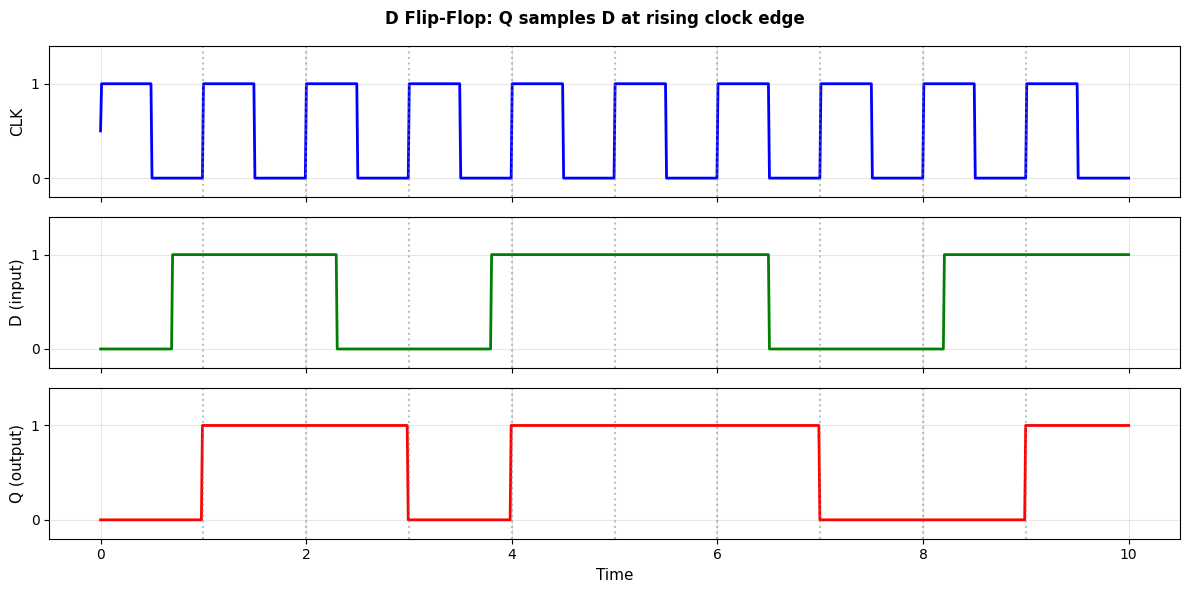

In [3]:
# Timing diagram: D flip-flop
fig, axes = plt.subplots(3, 1, figsize=(12, 6), sharex=True)

t = np.linspace(0, 10, 1000)

# Clock
clk = 0.5 + 0.5 * np.sign(np.sin(2 * np.pi * t))
axes[0].plot(t, clk, 'b-', linewidth=2)
axes[0].set_ylabel('CLK', fontsize=11)
axes[0].set_ylim(-0.2, 1.4)
axes[0].set_yticks([0, 1])
axes[0].grid(True, alpha=0.3)

# D input (changes asynchronously)
d = np.zeros_like(t)
d[t > 0.7] = 1
d[t > 2.3] = 0
d[t > 3.8] = 1
d[t > 6.5] = 0
d[t > 8.2] = 1
axes[1].plot(t, d, 'g-', linewidth=2)
axes[1].set_ylabel('D (input)', fontsize=11)
axes[1].set_ylim(-0.2, 1.4)
axes[1].set_yticks([0, 1])
axes[1].grid(True, alpha=0.3)

# Q output (samples D at clock rising edges)
q = np.zeros_like(t)
rising_edges = [1, 2, 3, 4, 5, 6, 7, 8, 9]
current_q = 0
for i, ti in enumerate(t):
    # Check for rising edge
    for edge in rising_edges:
        if abs(ti - edge) < 0.01:
            current_q = d[i]
    q[i] = current_q

axes[2].plot(t, q, 'r-', linewidth=2)
axes[2].set_ylabel('Q (output)', fontsize=11)
axes[2].set_xlabel('Time', fontsize=11)
axes[2].set_ylim(-0.2, 1.4)
axes[2].set_yticks([0, 1])
axes[2].grid(True, alpha=0.3)

# Mark rising edges
for edge in rising_edges:
    for ax in axes:
        ax.axvline(x=edge, color='gray', linestyle=':', alpha=0.5)

plt.suptitle('D Flip-Flop: Q samples D at rising clock edge', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

---
<a id="5-state-machines"></a>
# 5. State Machines
---

A **Finite State Machine (FSM)** is a circuit that moves between states based on inputs.

### FSM Template

```verilog
// State encoding
localparam IDLE = 2'b00,
           RUN  = 2'b01,
           DONE = 2'b10;

reg [1:0] state;

always @(posedge clk or negedge rst_n) begin
    if (!rst_n) begin
        state <= IDLE;
    end
    else begin
        case (state)
            IDLE: if (start) state <= RUN;
            RUN:  if (count == 0) state <= DONE;
            DONE: state <= IDLE;
            default: state <= IDLE;
        endcase
    end
end
```

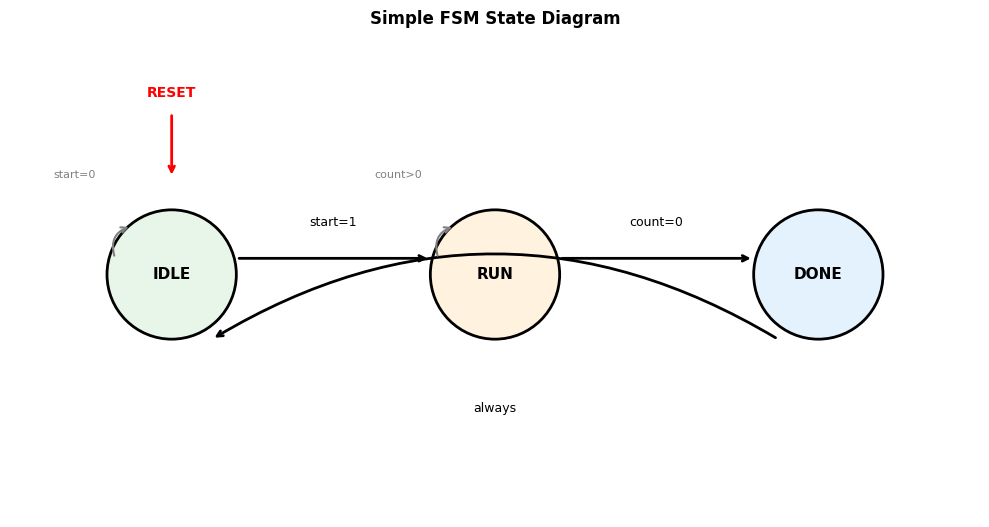

In [4]:
# State machine diagram
fig, ax = plt.subplots(figsize=(10, 6))

# States as circles
states = [
    ('IDLE', 2, 3, '#E8F5E9'),
    ('RUN', 6, 3, '#FFF3E0'),
    ('DONE', 10, 3, '#E3F2FD'),
]

for name, x, y, color in states:
    circle = Circle((x, y), 0.8, facecolor=color, edgecolor='black', linewidth=2)
    ax.add_patch(circle)
    ax.text(x, y, name, ha='center', va='center', fontsize=11, fontweight='bold')

# Transitions
# IDLE -> RUN
ax.annotate('', xy=(5.2, 3.2), xytext=(2.8, 3.2),
           arrowprops=dict(arrowstyle='->', color='black', lw=2))
ax.text(4, 3.6, 'start=1', ha='center', fontsize=9)

# RUN -> DONE
ax.annotate('', xy=(9.2, 3.2), xytext=(6.8, 3.2),
           arrowprops=dict(arrowstyle='->', color='black', lw=2))
ax.text(8, 3.6, 'count=0', ha='center', fontsize=9)

# DONE -> IDLE
ax.annotate('', xy=(2.5, 2.2), xytext=(9.5, 2.2),
           arrowprops=dict(arrowstyle='->', color='black', lw=2,
                          connectionstyle='arc3,rad=0.3'))
ax.text(6, 1.3, 'always', ha='center', fontsize=9)

# Self-loops
# IDLE stays
ax.annotate('', xy=(1.5, 3.6), xytext=(1.3, 3.2),
           arrowprops=dict(arrowstyle='->', color='gray', lw=1.5,
                          connectionstyle='arc3,rad=-0.5'))
ax.text(0.8, 4.2, 'start=0', ha='center', fontsize=8, color='gray')

# RUN stays
ax.annotate('', xy=(5.5, 3.6), xytext=(5.3, 3.2),
           arrowprops=dict(arrowstyle='->', color='gray', lw=1.5,
                          connectionstyle='arc3,rad=-0.5'))
ax.text(4.8, 4.2, 'count>0', ha='center', fontsize=8, color='gray')

# Reset arrow
ax.annotate('', xy=(2, 4.2), xytext=(2, 5),
           arrowprops=dict(arrowstyle='->', color='red', lw=2))
ax.text(2, 5.2, 'RESET', ha='center', fontsize=10, color='red', fontweight='bold')

ax.set_xlim(0, 12)
ax.set_ylim(0, 6)
ax.set_aspect('equal')
ax.set_title('Simple FSM State Diagram', fontsize=12, fontweight='bold')
ax.axis('off')

plt.tight_layout()
plt.show()

---
<a id="6-testbenches"></a>
# 6. Testbenches
---

A **testbench** is Verilog code that tests your design.

### Testbench Template

```verilog
`timescale 1ns/1ps

module my_module_tb;
    // Inputs are reg (we drive them)
    reg clk, rst_n, data_in;
    
    // Outputs are wire (DUT drives them)
    wire data_out;
    
    // Instantiate Device Under Test
    my_module dut (
        .clk(clk),
        .rst_n(rst_n),
        .data_in(data_in),
        .data_out(data_out)
    );
    
    // Clock generation
    always #10 clk = ~clk;  // 50 MHz (20ns period)
    
    // Test stimulus
    initial begin
        $dumpfile("waves.vcd");
        $dumpvars(0, my_module_tb);
        
        // Initialize
        clk = 0;
        rst_n = 0;
        data_in = 0;
        
        // Reset
        #40 rst_n = 1;
        
        // Test cases
        #20 data_in = 1;
        #20 data_in = 0;
        
        #200 $finish;
    end
endmodule
```

**Note on simulation timing**: Testbenches often use faster clocks than the target hardware to speed up simulation. If your design uses `parameter CLK_FREQ = 50_000_000` (50 MHz), the testbench clock period doesn't need to match—the design behavior is the same. Our examples use 1 MHz in testbenches for faster simulation, but the template above matches the 50 MHz target for clarity.

---
<a id="7-simulation--debugging"></a>
# 7. Simulation & Debugging
---

### Running Simulation

```bash
# Compile
iverilog -o sim.vvp my_module.v my_module_tb.v

# Run
vvp sim.vvp

# View waveforms
gtkwave waves.vcd
```

### Debug Prints

```verilog
$display("Value of x = %d", x);       // Print once
$monitor("x=%d y=%d", x, y);          // Print on any change
$time                                  // Current simulation time
```

### Linting

```bash
# Check for common errors
verilator --lint-only my_module.v
```

---
<a id="7-self-checking-testbenches"></a>
# 7. Self-Checking Testbenches
---

A **self-checking testbench** automatically verifies correctness instead of requiring you to manually inspect waveforms.

### Why Self-Checking?

| Manual Checking | Self-Checking |
|-----------------|---------------|
| Stare at waveforms | Automatic pass/fail |
| Error-prone | Catches regressions |
| Doesn't scale | Runs in CI/CD |
| "Looks right..." | Quantified results |

### Self-Checking Testbench Pattern

```verilog
`timescale 1ns/1ps

module adder_tb;
    reg [7:0] a, b;
    wire [8:0] sum;
    
    // Track test results
    integer pass_count = 0;
    integer fail_count = 0;
    
    adder dut (.a(a), .b(b), .sum(sum));
    
    // Task to check one test case
    task check_add;
        input [7:0] test_a, test_b;
        input [8:0] expected;
        begin
            a = test_a;
            b = test_b;
            #1; // Wait for combinational logic
            
            if (sum === expected) begin
                pass_count = pass_count + 1;
            end
            else begin
                $display("FAIL: %d + %d = %d, expected %d", 
                         test_a, test_b, sum, expected);
                fail_count = fail_count + 1;
            end
        end
    endtask
    
    initial begin
        // Run test cases
        check_add(8'd0,   8'd0,   9'd0);
        check_add(8'd1,   8'd1,   9'd2);
        check_add(8'd255, 8'd1,   9'd256);
        check_add(8'd255, 8'd255, 9'd510);
        check_add(8'd100, 8'd50,  9'd150);
        
        // Report results
        $display("=====================================");
        $display("Test complete: %0d passed, %0d failed", 
                 pass_count, fail_count);
        
        if (fail_count == 0)
            $display("SUCCESS: All tests passed!");
        else
            $display("FAILURE: Some tests failed!");
        
        $finish;
    end
endmodule
```

### Key Techniques

| Technique | Purpose |
|-----------|---------|
| **`===` operator** | Compares including X and Z (use for simulation) |
| **`$error`** | Report errors (SystemVerilog) |
| **Pass/fail counters** | Summary at end |
| **Tasks** | Reusable test code |
| **Expected values** | Golden reference to compare against |

### For Sequential Designs

Add clock and check after known delays:

```verilog
// Wait for known number of cycles
repeat (10) @(posedge clk);

// Then check
if (dut.state !== EXPECTED_STATE) begin
    $display("FAIL: state = %b, expected %b", dut.state, EXPECTED_STATE);
    fail_count = fail_count + 1;
end
```

### Beyond Verilog Testbenches

For complex sequential logic and larger projects, **cocotb** (Coroutine-based Cosimulation Testbench) lets you write testbenches in Python:

```python
# Example cocotb test (NOT used in this course)
import cocotb
from cocotb.triggers import RisingEdge

@cocotb.test()
async def test_adder(dut):
    dut.a.value = 5
    dut.b.value = 3
    await RisingEdge(dut.clk)
    assert dut.sum.value == 8, f"Expected 8, got {dut.sum.value}"
```

**Why cocotb?** Python provides easier randomization, assertions, and complex test sequencing. It's widely used in industry but outside our course scope. Learn more: https://www.cocotb.org/

**For this course**: We use Verilog testbenches since they require no additional setup beyond Icarus Verilog.

---
<a id="8-clock-domain-crossing"></a>
# 8. Clock Domain Crossing (CDC)
---

When signals cross between different clock domains, you must handle **metastability** or your design will fail randomly.

### The Problem: Metastability

When a flip-flop samples a changing input, it can enter an unstable state:

```
     ┌─────────────────────────────────────────────────────┐
     │ Sampling window: setup + hold time                 │
     │                                                     │
     │    Setup time        Hold time                      │
     │    ◄───────┼─────────►                              │
     │            │                                        │
     │    ────────┼──────── Clock edge                     │
     │            │                                        │
     │  If input changes HERE, flip-flop may go metastable │
     └─────────────────────────────────────────────────────┘
```

When metastable, the output is **neither 0 nor 1** - it's somewhere in between, and may stay there for an unpredictable time before resolving.

### The Solution: Synchronizers

A **2-stage synchronizer** gives the signal time to resolve:

```verilog
// Two flip-flops in series = synchronizer
reg [1:0] sync_reg;

always @(posedge clk_b or negedge rst_n) begin
    if (!rst_n)
        sync_reg <= 2'b00;
    else
        sync_reg <= {sync_reg[0], async_input};  // Shift in
end

wire synced_output = sync_reg[1];  // Use the second stage
```

**How it works:**
1. First flip-flop may go metastable (that's okay)
2. It has one full clock cycle to resolve before the second flip-flop samples it
3. Second flip-flop sees a clean 0 or 1

### When You Need Synchronizers

| Crossing | Synchronizer Needed? |
|----------|---------------------|
| External button input | Yes - async to your clock |
| Signal from different clock | Yes - different frequency or phase |
| Signal within same clock domain | No |
| Reset signal (async) | Yes - use reset synchronizer |

### Our Examples Use Synchronizers

In `pocket_synth.v`, button inputs are synchronized:

```verilog
// From the debounce module
reg [1:0] btn_sync;
always @(posedge clk) begin
    btn_sync <= {btn_sync[0], btn_raw};  // 2-stage sync
end
wire btn_clean = btn_sync[1];
```

### Multi-Bit Signals: Use a FIFO or Handshake

**Never synchronize multi-bit buses directly** - each bit might resolve at different times, creating invalid values.

For multi-bit data crossing:

| Approach | Use When |
|----------|----------|
| **Gray code** | Counters/pointers (only 1 bit changes at a time) |
| **Async FIFO** | Streaming data between domains |
| **Handshake** | Occasional transfers with request/acknowledge |

### Simple Handshake Pattern

```verilog
// In clock domain A: send data
always @(posedge clk_a) begin
    if (send_data) begin
        data_reg <= data_to_send;
        req <= 1;          // Assert request
    end
    else if (ack_sync)     // Wait for synchronized ack
        req <= 0;          // Clear request
end

// In clock domain B: receive data
always @(posedge clk_b) begin
    if (req_sync && !ack) begin
        received_data <= data_reg;  // Safe to read
        ack <= 1;                   // Acknowledge
    end
    else if (!req_sync)
        ack <= 0;
end
```

**Note**: Our course projects use single clock domains to avoid these complexities. CDC becomes important when integrating multiple IP blocks or interfaces with different clocks.

### Reset Synchronization

Asynchronous resets (from buttons, external chips) need special handling:

```verilog
// Reset Synchronizer: async assert, sync deassert
module reset_sync (
    input  wire clk,
    input  wire rst_n_async,  // Async reset input (active low)
    output wire rst_n_sync    // Synchronized reset output
);
    reg [1:0] sync_reg;
    
    always @(posedge clk or negedge rst_n_async) begin
        if (!rst_n_async)
            sync_reg <= 2'b00;  // Async assert (immediate)
        else
            sync_reg <= {sync_reg[0], 1'b1};  // Sync deassert
    end
    
    assign rst_n_sync = sync_reg[1];
endmodule
```

**Why this works:**
- **Async assertion**: Reset takes effect immediately (no clock needed)
- **Sync deassertion**: Reset releases cleanly aligned to clock edge
- **No metastability on deassert**: The synchronizer cleans up the edge

**Usage:**
```verilog
wire rst_n_internal;
reset_sync u_reset_sync (
    .clk(clk),
    .rst_n_async(rst_n_pin),
    .rst_n_sync(rst_n_internal)
);

// Use rst_n_internal for all your logic
always @(posedge clk or negedge rst_n_internal) begin
    if (!rst_n_internal)
        // ...
end
```

**Common mistake**: Using the raw external reset directly:
```verilog
// BAD: Unsynchronized reset can cause metastability
always @(posedge clk or negedge rst_n_pin)  // Don't do this!
    if (!rst_n_pin) ...
```

---
<a id="9-advanced-constructs"></a>
# 9. Advanced Constructs
---

These constructs are used in the course example projects.

### Generate Blocks

`generate` lets you create multiple instances or conditional hardware:

```verilog
// Create 4 identical synchronizers
genvar i;
generate
    for (i = 0; i < 4; i = i + 1) begin : sync_gen
        reg [1:0] sync;
        always @(posedge clk) begin
            sync <= {sync[0], input_bus[i]};
        end
        assign synced[i] = sync[1];
    end
endgenerate
```

Used in: `pocket_synth.v` for key synchronizers.

### System Functions

**$clog2** - Calculate bits needed for a value:

```verilog
// How many bits to count to 1000?
localparam COUNT_MAX = 1000;
localparam WIDTH = $clog2(COUNT_MAX + 1);  // = 10 bits

reg [WIDTH-1:0] counter;  // 10-bit counter
```

Used in: `uart_tx.v`, `debounce.v` for counter sizing.

### Localparam vs Parameter

```verilog
parameter  CLK_FREQ = 50_000_000;  // Can be overridden when instantiating
localparam HALF = CLK_FREQ / 2;    // Calculated, cannot be overridden
```

---
<a id="10-common-mistakes"></a>
# 10. Common Mistakes
---

### ❌ Unintentional Latches

```verilog
// BAD: Missing else creates a latch!
always @(*) begin
    if (sel)
        y = a;
    // What about when sel=0? Latch inferred!
end

// GOOD: All cases covered
always @(*) begin
    if (sel)
        y = a;
    else
        y = b;
end
```

### ❌ Mixing Blocking/Non-Blocking

```verilog
// BAD: Using = in sequential logic
always @(posedge clk)
    q = d;    // Should be <=

// GOOD
always @(posedge clk)
    q <= d;
```

### ❌ Incomplete Sensitivity List

```verilog
// BAD: Missing 'b' in sensitivity list
always @(a)
    y = a & b;    // Won't update when b changes!

// GOOD: Use @(*) for combinational
always @(*)
    y = a & b;
```

---
<a id="11-lint-warnings"></a>
# 11. Lint Warnings
---

**Linting** catches bugs before simulation. Always run a linter!

### Running Verilator Lint

```bash
# Check for warnings (lint only, don't compile)
verilator --lint-only -Wall my_module.v

# With specific warnings enabled
verilator --lint-only -Wall -Wno-UNUSED my_module.v
```

### Common Warnings and Fixes

#### LATCH - Unintentional Latch Inferred

```
%Warning-LATCH: my_module.v:15: Latch inferred for signal 'y'
```

**Cause**: Combinational always block doesn't assign output in all branches.

```verilog
// BAD: Latch inferred
always @(*) begin
    case (sel)
        2'b00: y = a;
        2'b01: y = b;
        // Missing 2'b10 and 2'b11!
    endcase
end

// GOOD: Add default case
always @(*) begin
    case (sel)
        2'b00: y = a;
        2'b01: y = b;
        default: y = 0;  // Cover all cases
    endcase
end
```

#### BLKSEQ - Blocking Assignment in Sequential Block

```
%Warning-BLKSEQ: my_module.v:22: Blocking assignment in sequential block
```

**Cause**: Using `=` instead of `<=` in clocked always block.

```verilog
// BAD: Blocking in sequential
always @(posedge clk)
    q = d;    // Warning: should be <=

// GOOD: Non-blocking for sequential
always @(posedge clk)
    q <= d;
```

#### WIDTH - Width Mismatch

```
%Warning-WIDTH: my_module.v:10: Operator ASSIGN width mismatch (8 != 4)
```

**Cause**: Signal widths don't match in assignment.

```verilog
wire [7:0] wide;
wire [3:0] narrow;

// BAD: Implicit truncation
assign narrow = wide;  // Warning: losing 4 bits

// GOOD: Explicit truncation
assign narrow = wide[3:0];  // Clear intent
```

#### UNUSED - Unused Signal

```
%Warning-UNUSED: my_module.v:5: Signal 'debug_temp' is not used
```

**Cause**: Declared signal is never read.

```verilog
// BAD: Unused signal
wire debug_temp = internal_value;  // Never used

// Options:
// 1. Remove it if not needed
// 2. If intentional, mark it:
/* verilator lint_off UNUSED */
wire debug_temp = internal_value;
/* verilator lint_on UNUSED */
```

#### UNOPTFLAT - Circular Combinational Logic

```
%Warning-UNOPTFLAT: Signal forms circular logic with itself
```

**Cause**: Combinational feedback loop (bad!).

```verilog
// BAD: Combinational loop
wire a = b;
wire b = a;  // Circular!

// GOOD: Break loop with register
always @(posedge clk)
    a <= b;
```

#### CASEINCOMPLETE - Case Not Fully Covered

```
%Warning-CASEINCOMPLETE: Case values not fully covered
```

```verilog
// BAD: Missing cases
always @(*) begin
    case (state)
        IDLE: next_state = RUN;
        RUN:  next_state = DONE;
        // What about DONE?
    endcase
end

// GOOD: Cover all cases
always @(*) begin
    case (state)
        IDLE:    next_state = RUN;
        RUN:     next_state = DONE;
        DONE:    next_state = IDLE;
        default: next_state = IDLE;
    endcase
end
```

### Treating Warnings as Errors

For production code, make warnings fail the build:

```bash
verilator --lint-only -Wall -Werror-LATCH -Werror-WIDTH my_module.v
```

### Quick Reference: Warning Severity

| Warning | Severity | Must Fix? |
|---------|----------|-----------|
| LATCH | High | Yes - usually a bug |
| BLKSEQ | High | Yes - race conditions |
| UNOPTFLAT | High | Yes - design won't work |
| WIDTH | Medium | Review carefully |
| CASEINCOMPLETE | Medium | Add default case |
| UNUSED | Low | Clean up for production |
| PINMISSING | Low | Check intentional |

**Rule of thumb**: Fix all warnings. If truly intentional, add a comment explaining why and use `/* verilator lint_off */` pragmas.

---
<div style="background: linear-gradient(135deg, #1a1a2e 0%, #16213e 100%); color: white; padding: 30px; margin: 20px -10px -10px -10px; border-radius: 15px 15px 0 0; text-align: center;">

## Summary

- **RTL** = Registers + Combinational Logic + Clock
- Use `wire` + `assign` for combinational
- Use `reg` + `always @(posedge clk)` for sequential
- **FSMs** organize sequential behavior
- **Testbenches** verify your design before synthesis

### Homework
1. Write/modify Verilog for your project
2. Create a testbench
3. Simulate and view waveforms in GTKWave
4. Run linter, fix any warnings

</div>